## Data Preprecessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
wl = 60  # how many days the model uses to predict the next day
test_period = 20

### Load and split data

In [3]:
dataset = pd.read_csv('BTC-USD.csv')['Close']
data = dataset.values.reshape(-1,1) # get np array version

In [4]:
def train_test_split(data, test_period):
    data_train = data[:-test_period]
    data_test = data[-test_period:]
    return data_train, data_test

In [5]:
train, test = train_test_split(data, test_period)

### Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

### Windowing Data

In [8]:
X_train = np.array([train_scaled[i-wl:i, 0] for i in range(wl, len(train))])
y_train = np.array([train_scaled[i, 0] for i in range(wl, len(train))])

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

In [14]:
def build_lstm_model(data, num_neurons = 50, activ_func='linear', 
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    # layer 1
    model.add(LSTM(units=num_neurons, return_sequences=True, input_shape=(data.shape[1], 1)))
    model.add(Dropout(dropout))
    # layer 2
    model.add(LSTM(units=num_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    # layer 3
    model.add(LSTM(units=num_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    # layer 4
    model.add(LSTM(units=num_neurons))
    model.add(Dropout(dropout))
    # ouput layer
    model.add(Dense(units=1))
    # model.add(Activation(activ_func))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [15]:
model = build_lstm_model(X_train)

## Training the Model

In [16]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Train on 1958 samples
Epoch 1/100
1958/1958 [==============================] - 10s 5ms/sample - loss: 0.009412s - 
Epoch 2/100
1958/1958 [==============================] - 1s 673us/sample - loss: 0.0029
Epoch 3/100
1958/1958 [==============================] - 1s 465us/sample - loss: 0.0031
Epoch 4/100
1958/1958 [==============================] - 1s 465us/sample - loss: 0.0024
Epoch 5/100
1958/1958 [==============================] - 1s 464us/sample - loss: 0.0025
Epoch 6/100
1958/1958 [==============================] - 1s 449us/sample - loss: 0.0023
Epoch 7/100
1958/1958 [==============================] - 1s 450us/sample - loss: 0.0019
Epoch 8/100
1958/1958 [==============================] - 1s 451us/sample - loss: 0.0025
Epoch 9/100
1958/1958 [==============================] - 1s 448us/sample - loss: 0.0021
Epoch 10/100
1958/1958 [==============================] - 1s 444us/sample - loss: 0.0019
Epoch 11/100
1958/1958 [==============================] - 1s 439us/sample - loss: 0.0015
Epo

## Testing the Model

### Get Predicted Values

Need to use predict in a for loop, where it takes the previous wl days and predicts the next day, then shifts along and predicts the next day where the 60th input entry is the previous prediction.

PREDICTIONS CANNOT BE BASED ON TEST DATA - Unlike Fillipos and that Udemy course

In [17]:
inputs = sc.transform(train[-wl:])
preds = np.array([])
for i in range(len(test)):
    # Make and store prediction:
    X_test = np.reshape(inputs, (1, inputs.shape[0], inputs.shape[1]))
    prediction = model.predict(X_test)
    preds = np.append(preds, prediction)
    # update inputs:
    inputs = np.append(inputs, prediction)
    inputs = inputs[1:].reshape(-1,1)
preds = sc.inverse_transform(preds.reshape(-1,1))

### Plot predicted values versus expected values

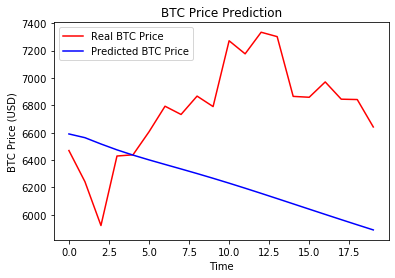

In [18]:
plt.plot(test, color = 'red', label = 'Real BTC Price')
plt.plot(preds, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.show()